# Assignment Briefing

- Context: One challenge of modeling retail data is the need to make decisions based on limited history. Holidays and select major events come once a year, and so does the chance to see how strategic decisions impacted the bottom line. In addition, markdowns are known to affect sales – the challenge is to predict which departments will be affected and to what extent.

- Content: You are provided with historical sales data for 45 stores located in different regions - each store contains a number of departments. The company also runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks.

1. Stores: Anonymized information about the 45 stores, indicating the type and size of store

2. Features: Contains additional data related to the store, department, and regional activity for the given dates.

    - Store - the store number
    - Date - the week
    - Temperature - average temperature in the region
    - Fuel_Price - cost of fuel in the region
    - MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for  all stores all the time. Any missing value is marked with an NA
    - CPI - the consumer price index
    - Unemployment - the unemployment rate
    - IsHoliday - whether the week is a special holiday week


3. Sales: Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

    - Store - the store number
    - Dept - the department number
    - Date - the week
    - Weekly_Sales -  sales for the given department in the given store
    - IsHoliday - whether the week is a special holiday week
    

- The Tasks:

    1. Download the three data sets: one on stores, one on features and one on sales. Merge them and clean the data (deal with missing variables, outliers, etc.).
    2. Explore the data and perform visualizations you deem appropriate. Make sure to pay attention to the target – the weekly sales -- and how it relates to other features. Do you see some seasonality in the target and, if yes, then what kind?
    3. Train a model (or models) that predicts the weekly sales in a department store. This is a time series problem so be careful with the train-test split (hint: you do not want to perform a random split here, think about the time horizon). Evaluate the model you have trained and reason about how the store managers can use your forecast to better anticipate sales fluctuations.

# Import Data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import datetime as dt


from fbprophet import Prophet
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

data1 = pd.read_csv(r'C:\Users\ams-duongn.EXPEDITORS\Desktop\learn\Data Science Master\M6W6\stores data-set.csv')
data2 = pd.read_csv(r'C:\Users\ams-duongn.EXPEDITORS\Desktop\learn\Data Science Master\M6W6\Features data set.csv')
data3 = pd.read_csv(r'C:\Users\ams-duongn.EXPEDITORS\Desktop\learn\Data Science Master\M6W6\sales data-set.csv')

In [2]:
data1.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
data2.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


- First we import all the data available
- And then take a preview about the data
- For the first section, i want to take a deeper look about first data which is Store Data

# Stores Data

In [5]:
data1.shape

(45, 3)

In [6]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [7]:
'''Nunique Columns'''

def nunique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
    
nunique_counts(data1)

Store :  45
Type :  3
Size :  40


In [8]:
data1['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

Text(0.5, 1.0, 'Ratio of missing values per columns')

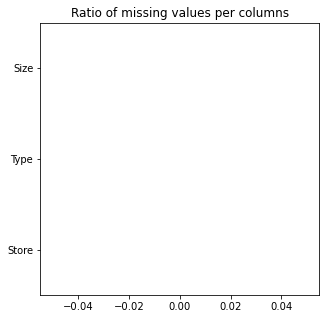

In [9]:
'''Missing Value Chart'''

plt.figure(figsize=(5, 5))
data1.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [10]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(data1.duplicated().sum()))
# data1.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [11]:
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go 
import plotly.tools as tools
import warnings
warnings.filterwarnings("ignore")
from collections import Counter 
import plotly.io as pio
import plotly.express as px

pio.templates.default = "seaborn"

labels = data1['Store'].tolist()
values = data1['Size'].tolist()

fig = px.pie(data1, values=values, names=labels)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Store by Size')
fig.show()

In [12]:
custom_aggregation = {}
custom_aggregation["Size"] = "mean"
data0 = data1.groupby("Type").agg(custom_aggregation)
data0.columns = ["Size"]
data0['Type'] = data0.index

fig = px.bar(data0, x='Type', y="Size", color="Type")
fig['layout'].update(height=400, width=550, title='Size of Type Store')
fig.show()

In [13]:
custom_aggregation = {}
custom_aggregation["Store"] = "count"
data0 = data1.groupby("Type").agg(custom_aggregation)
data0.columns = ["Store Count"]
data0['Type'] = data0.index

fig = px.bar(data0, x='Type', y="Store Count", color="Type")
fig['layout'].update(height=400, width=550, title='Nb. of Store Based on Type Store')
fig.show()

- From Store by Size graph, we can see that the majority of the store have similar size around(1,77% - 3,75%)
- Typa A store have store count more that other type store (B and C), and also have the largest size

# Features Data

In [14]:
data2.shape

(8190, 12)

In [15]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [16]:
nunique_counts(data2)

Store :  45
Date :  182
Temperature :  4178
Fuel_Price :  1011
MarkDown1 :  4023
MarkDown2 :  2715
MarkDown3 :  2885
MarkDown4 :  3405
MarkDown5 :  4045
CPI :  2505
Unemployment :  404
IsHoliday :  2


In [17]:
data2['IsHoliday'].unique()

array([False,  True])

Text(0.5, 1.0, 'Ratio of missing values per columns')

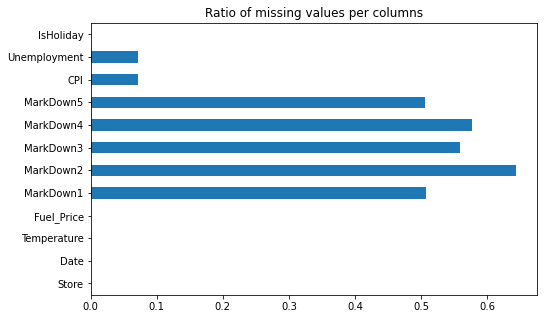

In [18]:
plt.figure(figsize=(8, 5))
data2.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [19]:
data2.isnull().sum().sort_values(ascending=False)

MarkDown2       5269
MarkDown4       4726
MarkDown3       4577
MarkDown1       4158
MarkDown5       4140
CPI              585
Unemployment     585
Store              0
Date               0
Temperature        0
Fuel_Price         0
IsHoliday          0
dtype: int64

In [20]:
data2[data2.isnull().T.any().T].head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [21]:
data2.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [22]:
data2['Date'] = pd.to_datetime(data2['Date']) #datetime format
data3['Date'] = pd.to_datetime(data3['Date']) #datetime format
data2['Year'] = data2['Date'].dt.year # getting year
data2['Month'] = data2['Date'].dt.month # getting month
data2['Day'] = data2['Date'].dt.day # getting day

In [23]:
'''Equidistance Checking'''

data0 = data2.sort_values(by='Date')
data0['Time_Interval'] = data0.Date - data0.Date.shift(1)
data0[['Date', 'Time_Interval']].head()

print(f"{data0['Time_Interval'].value_counts().sort_values(ascending=False)}")

0 days     8008
7 days       77
3 days       19
8 days       17
10 days      10
11 days       9
6 days        9
1 days        7
4 days        5
12 days       5
5 days        4
13 days       4
9 days        4
15 days       2
14 days       2
18 days       1
33 days       1
63 days       1
25 days       1
21 days       1
27 days       1
2 days        1
Name: Time_Interval, dtype: int64


In [24]:
data2['Date'].min(), data2['Date'].max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2013-12-07 00:00:00'))

- After checking missing values, the most feature which have missing values are Markdown 1-5. Also Unemployment and CPI
- For now I'll leave the data as it is
- And for the Date, I convert it to datetimeformat. And also generate Year, Month and Day for further modeling

In [25]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["CPI"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["CPI"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['CPI'].tolist()
y_ = data0['CPI'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='CPI'), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate CPI'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Consumer Price Index (Average)')
fig.show()

In [26]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Unemployment"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Unemployment"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Unemployment'].tolist()
y_ = data0['Unemployment'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Unemployment',line=dict(color='firebrick', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Unemployment'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Unemployment Index (Average)')
fig.show()

In [27]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Temperature"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Temperature"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Temperature'].tolist()
y_ = data0['Temperature'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Temperature',line=dict(color='green', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Temperature'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Temperature (Average)')
fig.show()

In [28]:
fig = make_subplots(rows=1, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["Fuel_Price"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["Fuel_Price"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['Fuel_Price'].tolist()
y_ = data0['Fuel_Price'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Fuel_Price',line=dict(color='pink', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate Fuel_Price'), 1, 1)

fig['layout'].update(height=500, width=900, title='Monthly Fuel_Price (Average)')
fig.show()

- The idea of what i'm doing is: i try to resample the date to monthly basis to make visualization much clear
- We can see that the original data contain Nan data, and i use interpolate to complement the visualization.
- I prefer to use interpolate compared to mean, median etc
- As we can see, monthly Consumer Price Index (CPI) is increasing every month.

'Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is calculated by taking price changes for each item in the predetermined basket of goods and averaging them.' (www.investopedia.com)

- For the unemployment, is decrease every month.
- Temperatures vary each year, usually reaching the highest peak in May - August and the lowest in Nov - Feb.
- For fuel prices experienced a significant increase in January 2011 and did not experience a decline thereafter. In fact, the price tends to increase every month.

In [29]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown1"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown1"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown1'].tolist()
y_ = data0['MarkDown1'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown1',line=dict(color='darkorchid', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown1'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown1 (Average)')
fig.show()

In [30]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown2"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown2"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown2'].tolist()
y_ = data0['MarkDown2'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown2',line=dict(color='turquoise', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown2'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown2 (Average)')
fig.show()

In [31]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown3"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown3"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown3'].tolist()
y_ = data0['MarkDown3'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown3',line=dict(color='peru', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown3'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown3 (Average)')
fig.show()

In [32]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown4"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown4"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown4'].tolist()
y_ = data0['MarkDown4'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown4',line=dict(color='rosybrown', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown4'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)


#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown4 (Average)')
fig.show()

In [33]:
fig = make_subplots(rows=2, 
                    cols=1)

custom_aggregation = {}
custom_aggregation["MarkDown5"] = "mean"
data2 = data2.set_index(pd.DatetimeIndex(data2['Date']))
data0 = data2.resample('M').agg(custom_aggregation)
data0.columns = ["MarkDown5"]
data0['Date'] = data0.index

x = data0['Date'].tolist()
y = data0['MarkDown5'].tolist()
y_ = data0['MarkDown5'].interpolate().tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='MarkDown5',line=dict(color='navy', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x, y=y_,mode='markers',name='Interpolate MarkDown5'), 1, 1)

#-----------------------------------------------------------------------------------------------------

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('M').agg(custom_aggregation)
data0.columns = ["Monthly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Monthly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

#-----------------------------------------------------------------------------------------------------

# Crosstabbing
data2 = data2.reset_index(drop=True)
feature = ["IsHoliday", 'Date']
data0 = pd.crosstab(data2[feature[0]], data2[feature[1]]).T
data0['Date_'] = data0.index
data0.columns = ["Not Holiday", 'Is Holiday', 'Date_']

# Is Holiday
feature = ["Is Holiday", 'Date_']
data_a = pd.crosstab(data0[feature[0]], data0[feature[1]]).T
data_a['Date_'] = data_a.index
data_a.columns = ["No", 'Yes', 'Date_']

custom_aggregation = {}
custom_aggregation["No"] = "sum"
custom_aggregation["Yes"] = "sum"
data_a = data_a.resample('M').agg(custom_aggregation)
data_a['Date_'] = data_a.index

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['Yes'],
            name='Is Holiday'), 2, 1)

fig.add_trace(go.Bar(
            x = data_a['Date_'],
            y = data_a['No'],
            name='Not Holiday'), 2, 1)

fig['layout'].update(height=700, width=900, title='Monthly MarkDown5 (Average)')
fig.show()

- I counted the total week which is special week and visualize it in purple bar chart below the markdown chart
- And also plot the sales which overlay the markdown so that we can understand the relatiobship between sales, markdown and special week
- I make different visualization in every markdown
1. Markdown 1: The highest amount of markdown is in February - March 2012, but in that time there is no special week. Also the sales tends to stagnate. In Oct, Nov, Dec have 1 specal week but there is no markdown on that time.
2. Markdown 2: On Nov - Dec 2011 there are lots of special week, and the markdown also high. The sales experienced a significant increase at that time.
3. Markdown 3: On this type of Markdown, there are only 2 significant peaks which is in November 2011 and November 2012. In that month there is also a special week. But sales only increased significantly in November 2011.
4. Markdown 4: The highest markdown given is in Februari - March 2012 but not followed with occurrence of special week
5. Markdown 5: The amount of markdown in this type is lower than the others

# Sales Data

In [34]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [35]:
data3.shape

(421570, 5)

In [36]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [37]:
data3.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [38]:
nunique_counts(data3)

Store :  45
Dept :  81
Date :  143
Weekly_Sales :  359464
IsHoliday :  2


Text(0.5, 1.0, 'Ratio of missing values per columns')

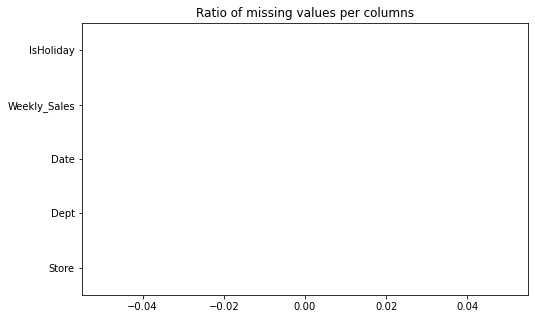

In [39]:
plt.figure(figsize=(8, 5))
data3.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [40]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(data3.duplicated().sum()))
# data3.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [41]:
data3.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [42]:
fig = make_subplots(rows=1, 
                    cols=1)

data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Lose Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Weekly Lose Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Lose Sales',line=dict(color='red', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Overall Weekly Lose Sales')
fig.show()

In [43]:
data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Store").agg(custom_aggregation)
data0.columns = ["Lose Sales"]
data0['Store'] = data0.index
data0['Lose Sales'] = abs(data0['Lose Sales'])

Store = data0['Store'].tolist()
Sales = data0['Lose Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Store)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Lose Sales by Store')
fig.show()

In [44]:
data3_0 = data3.loc[data3['Weekly_Sales'] < 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Dept").agg(custom_aggregation)
data0.columns = ["Lose Sales"]
data0['Dept'] = data0.index
data0['Lose Sales'] = abs(data0['Lose Sales'])

Dept = data0['Dept'].tolist()
Sales = data0['Lose Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Dept)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Lose Sales by Dept')
fig.show()

In [45]:
fig = make_subplots(rows=1, 
                    cols=1)

data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Weekly Profit Sales'].tolist()

fig.add_trace(go.Scatter(x=x, y=y,name='Profit Sales',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Overall Weekly Profit Sales')
fig.show()

In [46]:
data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Store").agg(custom_aggregation)
data0.columns = ["Profit Sales"]
data0['Store'] = data0.index

Store = data0['Store'].tolist()
Sales = data0['Profit Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Store)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Profit Sales by Store')
fig.show()

In [47]:
data3_0 = data3.loc[data3['Weekly_Sales'] > 0]
data3_0 = data3_0.rename(columns={'Date':'Date_'}, inplace=False)

custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data0 = data3_0.groupby("Dept").agg(custom_aggregation)
data0.columns = ["Profit Sales"]
data0['Dept'] = data0.index

Dept = data0['Dept'].tolist()
Sales = data0['Profit Sales'].tolist()

fig = px.pie(data0, values=Sales, names=Dept)
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig['layout'].update(height=500, width=700, title='Profit Sales by Dept')
fig.show()

In [48]:
fig = make_subplots(rows=1, 
                    cols=1)

# Bad performance store
data3_0 = data3.loc[data3['Store'] == 28]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Weekly Profit Sales'].tolist()

# Good performance store
data3_0 = data3.loc[data3['Store'] == 20]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Profit Sales"]
data0['Date_'] = data0.index

x_ = data0['Date_'].tolist()
y_ = data0['Weekly Profit Sales'].tolist()


fig.add_trace(go.Scatter(x=x, y=y,name='Store 28 (Bad Perf.)',line=dict(color='red', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_, y=y_,name='Store 20 (Good Perf.)',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Compared Good and Bad Store Performance based on Weekly Profit Sales')
fig.show()

In [49]:
fig = make_subplots(rows=1, 
                    cols=1)

# Bad performance store
data3_0 = data3.loc[data3['Dept'] == 32]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Profit Sales"]
data0['Date_'] = data0.index

x = data0['Date_'].tolist()
y = data0['Weekly Profit Sales'].tolist()

# Good performance store
data3_0 = data3.loc[data3['Dept'] == 92]
custom_aggregation = {}
custom_aggregation["Weekly_Sales"] = "mean"
data3_0 = data3_0.set_index(pd.DatetimeIndex(data3_0['Date']))
data0 = data3_0.resample('W').agg(custom_aggregation)
data0.columns = ["Weekly Profit Sales"]
data0['Date_'] = data0.index

x_ = data0['Date_'].tolist()
y_ = data0['Weekly Profit Sales'].tolist()


fig.add_trace(go.Scatter(x=x, y=y,name='Dept 32 (Bad Perf.)',line=dict(color='red', width=2)), 1, 1)
fig.add_trace(go.Scatter(x=x_, y=y_,name='Dept 92 (Good Perf.)',line=dict(color='darkgreen', width=2)), 1, 1)

fig['layout'].update(height=500, width=900, title='Compared Good and Bad Dept Performance based on Weekly Profit Sales')
fig.show()

- I seperate the lose sales (negative) and the profit sales (positive). This is so that we can clearly see in which week the biggest loss occurred, because when we do aggregation using the mean the loss amount will be compensated by the profit in the visualization. 
- I also find out what store and dept both giving big loses or profit
- After that I also compare both store and dept which giving the highest proft and the lowest profit.
- For the monthly loses, we can see that the weeks in Feb, Aug, Sep is when usually the most significant sales decrease occurs.
- The worst performance is Store number 28 (-16.8%), and Dept number 32 (-19.35%)
- The best performance is Store number 20 (+4.25%), and Dept number 92 (+6.61%)
- For Store number 28 whose size is 3.52% and Store number 20 whose size is 3.48% of the Total Stores Size, wee can see that the size of the two store is not too different, but the difference in sales contribution is about 10K. It means that, the management shoult take aware of this thing, why Store number 28 has very bad performance, while the operational costs incurred are not much different from those of the best performing stores.
- And for Dept number 32 and 92 have very significant different in sales, which is about 50K
- Need further inspection about Dept number 32, because it give very low profit in the business.

# Correlation and Preparing Features for Training

In [50]:
all_data = data1.merge(data2).merge(data3)

In [51]:
all_data.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
0,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,1,24924.50
1,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,2,50605.27
2,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,3,13740.12
3,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,4,39954.04
4,1,A,151315,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2010,5,2,5,32229.38


Text(0.5, 1.0, 'Ratio of missing values per columns')

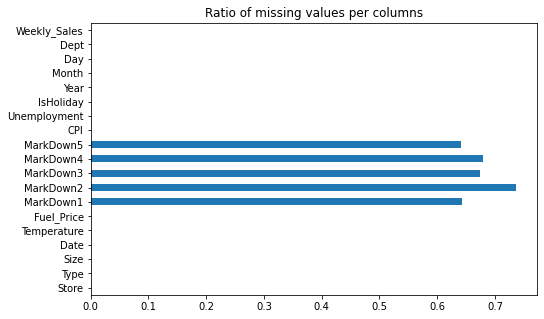

In [52]:
plt.figure(figsize=(8, 5))
all_data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [53]:
all_data['Date'].min(), all_data['Date'].max()

(Timestamp('2010-01-10 00:00:00'), Timestamp('2012-12-10 00:00:00'))

In [54]:
training = all_data.copy()

In [55]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Type          421570 non-null  object        
 2   Size          421570 non-null  int64         
 3   Date          421570 non-null  datetime64[ns]
 4   Temperature   421570 non-null  float64       
 5   Fuel_Price    421570 non-null  float64       
 6   MarkDown1     150681 non-null  float64       
 7   MarkDown2     111248 non-null  float64       
 8   MarkDown3     137091 non-null  float64       
 9   MarkDown4     134967 non-null  float64       
 10  MarkDown5     151432 non-null  float64       
 11  CPI           421570 non-null  float64       
 12  Unemployment  421570 non-null  float64       
 13  IsHoliday     421570 non-null  bool          
 14  Year          421570 non-null  int64         
 15  Month         421

In [56]:
training.shape

(421570, 19)

In [57]:
features = training.columns.values.tolist()

for col in features:
    training[col] = training[col].interpolate()

In [58]:
training.isnull().sum().sort_values(ascending=False) #missing values culomns

MarkDown4       6587
MarkDown1       6587
MarkDown2       6587
MarkDown3       6587
MarkDown5       6587
Unemployment       0
Dept               0
Day                0
Month              0
Year               0
IsHoliday          0
Store              0
CPI                0
Type               0
Fuel_Price         0
Temperature        0
Date               0
Size               0
Weekly_Sales       0
dtype: int64

In [59]:
training.dropna(inplace=True)

In [60]:
training.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
6587,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,1,18689.54
6588,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,2,44936.47
6589,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,3,9959.64
6590,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,4,36826.52
6591,1,A,151315,2011-11-11,59.11,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False,2011,11,11,5,31002.65


In [61]:
'''Checking Duplicate'''

print('Dupplicate entries: {}'.format(training.duplicated().sum()))
# data1.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [62]:
nunique_counts(training)

Store :  45
Type :  3
Size :  40
Date :  143
Temperature :  3488
Fuel_Price :  892
MarkDown1 :  266578
MarkDown2 :  305105
MarkDown3 :  279487
MarkDown4 :  281959
MarkDown5 :  265843
CPI :  2053
Unemployment :  342
IsHoliday :  2
Year :  3
Month :  12
Day :  31
Dept :  81
Weekly_Sales :  354138


In [63]:
'''Label Encoding With Label'''
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(training['Type'])

training['Type'] = le.transform(training['Type'])

l = [i for i in range(3)]
dict(zip(list(le.classes_), l))

{'A': 0, 'B': 1, 'C': 2}

In [64]:
le.fit(training['IsHoliday'])

training['IsHoliday'] = le.transform(training['IsHoliday'])

l = [i for i in range(2)]
dict(zip(list(le.classes_), l))

{False: 0, True: 1}

In [65]:
'''Min Max Scaler'''

from sklearn.preprocessing import MinMaxScaler

def normalize_col(data, column_to_keep):
    data = data[data.columns.difference(column_to_keep)]
    for col in data.columns.values.tolist():
        scaler = MinMaxScaler()
        data[col] = scaler.fit_transform(data[col].values.reshape(-1,1))
    return data

training_normalized = normalize_col(training, ['Year','Month','Day'])
training1 = pd.concat([training_normalized, training.loc[:, ['Year','Month','Day']]], axis=1)
training1.head(50)

,CPI,Date,Dept,Fuel_Price,IsHoliday,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Store,Temperature,Type,Unemployment,Weekly_Sales,Year,Month,Day
6587,0.90872,0.629108,0.000000,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.033919,2011,11,11
6588,0.90872,0.629108,0.010204,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.071517,2011,11,11
6589,0.90872,0.629108,0.020408,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.021414,2011,11,11
6590,0.90872,0.629108,0.030612,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.059900,2011,11,11
6591,0.90872,0.629108,0.040816,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.051557,2011,11,11
6592,0.90872,0.629108,0.051020,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.012200,2011,11,11
6593,0.90872,0.629108,0.061224,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.044309,2011,11,11
6594,0.90872,0.629108,0.071429,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.055856,2011,11,11
6595,0.90872,0.629108,0.081633,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.061108,2011,11,11
6596,0.90872,0.629108,0.091837,0.413327,0.0,0.117124,0.0609,0.001724,0.035664,0.059199,0.630267,0.0,0.598532,0.0,0.382116,0.053482,2011,11,11


In [66]:
training1.corr()['Weekly_Sales'].sort_values(ascending=False)[:8]

Weekly_Sales    1.000000
Size            0.245900
Dept            0.144387
MarkDown1       0.110701
MarkDown2       0.103349
MarkDown4       0.074705
MarkDown5       0.072457
MarkDown3       0.041821
Name: Weekly_Sales, dtype: float64

- First I combine all the data from different sets which yields the time range covered is between 2010-01-10 and 2012-12-10
- Weekly sales does not show any high correlation with any other parameters
- For the missing values we know that Markdown feature have so mach missing values. Instead to drop it, or fill it with 0 i prefer to chose interpolate
- After interpolating the feature, again checking for the missing values
- All the feature which already interpolate still have missing values, and we will drop all the rows
- And then trying to label encoding categorical data, and using min max scaler to make data tight
- After all the pre-processing step, we will start to modelling

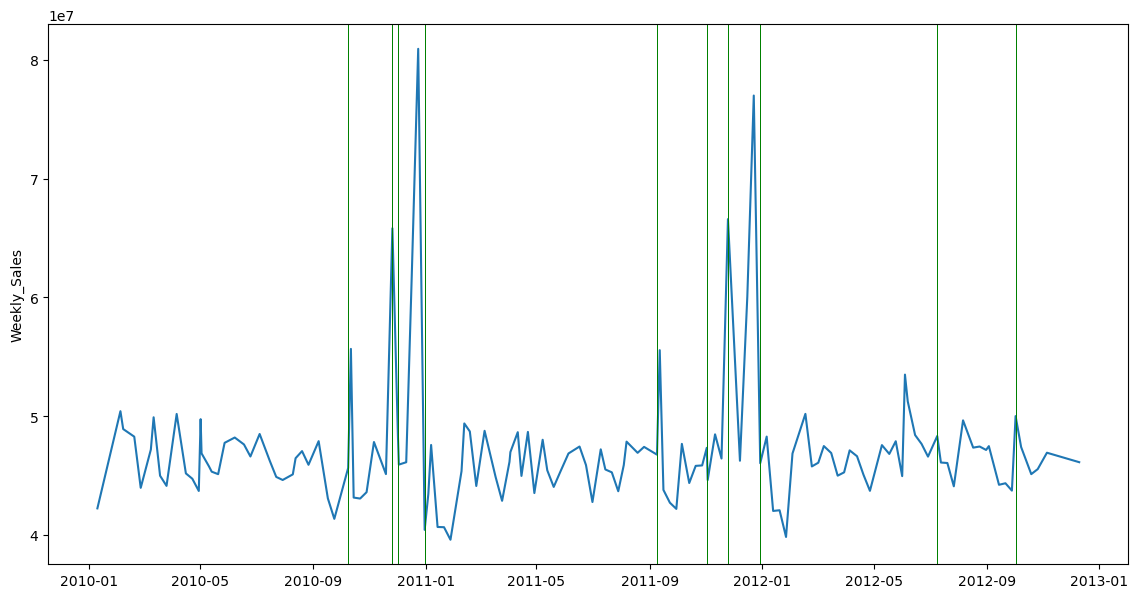

In [67]:
df = all_data.copy()
df['IsHolidayNumeric']=df['IsHoliday'].apply(lambda x:1 if (str(x)=="True") else 0) # converted holiday true false to 0 and 1 respectively
df2=df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
f_1 = plt.figure(figsize=(12,6), dpi=100)
ax_1 = f_1.add_axes([0.0, 0.0, 0.9, 0.9])
ax_1.set_ylabel('Weekly_Sales')
ax_1.plot(df2['Date'], df2['Weekly_Sales'])

for x in df[df['IsHolidayNumeric']==1]['Date']:
    ax_1.axvline(x=x, color='g', linewidth=0.5)

From the chart above, it is apparent that from october to december the sales went up which we can tell that there could be event or sale on product at that point of time. As denoted by the greenlines in the chart, we can see that holidays periods match with the peaks in sales so we can say that people are more likely to go to stores on holidays or events that creates the holidays.

# Predicting Sales

## FBProphet without Regressors

**Out of sample overall Sales forecast with Fbprophet model**

In [68]:
#Data Preparation for Fbprophet

df1 = training.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()

df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})

df1.tail()

,ds,y
138,2012-10-08,47403451.04
139,2012-10-19,45122410.57
140,2012-10-26,45544116.29
141,2012-11-05,46925878.99
142,2012-12-10,46128514.25


In [69]:
# define the model
model = Prophet(seasonality_mode = 'multiplicative')
# fit the model
model.fit(df1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [70]:
#Range of weeks for forecast
future_dates = pd.date_range("20121216","20141230", freq='W')
future_dates = [pd.to_datetime(i) for i in future_dates]
future = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in future_dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.138406e+07  5.628883e+07  6.662112e+07
1 2012-12-23  6.400159e+07  5.895151e+07  6.924538e+07
2 2012-12-30  5.886979e+07  5.361125e+07  6.425397e+07
3 2013-01-06  4.849398e+07  4.345134e+07  5.381879e+07
4 2013-01-13  4.040601e+07  3.528419e+07  4.565848e+07


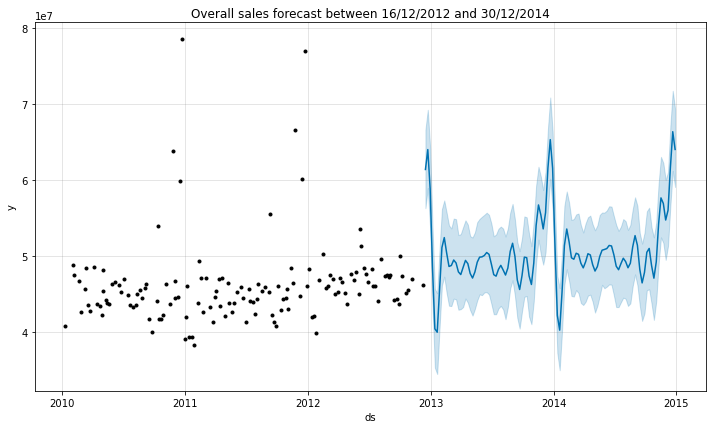

In [71]:
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title('Overall sales forecast between 16/12/2012 and 30/12/2014')
plt.show()

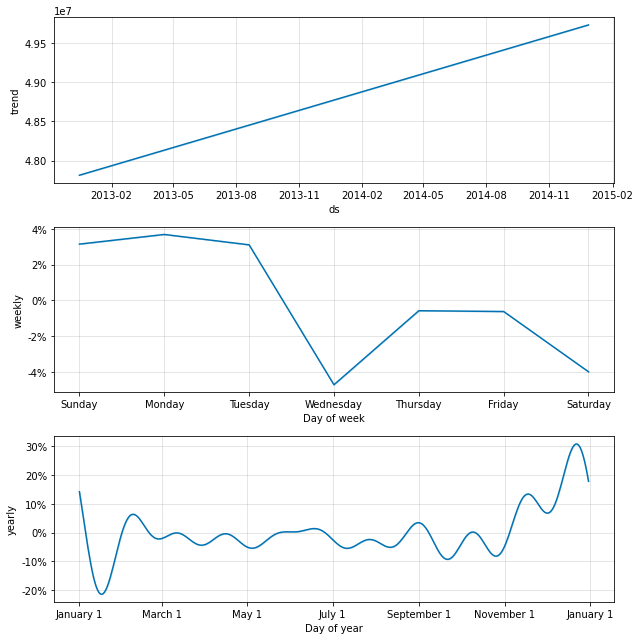

In [72]:
model.plot_components(forecast);

**In sample overall Sales forecast with Fbprophet model**

In [73]:
dates = pd.date_range("20111126","20121216", freq='W')
dates = [pd.to_datetime(i) for i in dates]
dates_for_forecast = pd.DataFrame([dt.datetime.strftime(i, '%Y-%m-%d') for i in dates],  columns=['ds'])

          ds          yhat    yhat_lower    yhat_upper
0 2012-12-16  6.138406e+07  5.628883e+07  6.662112e+07
1 2012-12-23  6.400159e+07  5.895151e+07  6.924538e+07
2 2012-12-30  5.886979e+07  5.361125e+07  6.425397e+07
3 2013-01-06  4.849398e+07  4.345134e+07  5.381879e+07
4 2013-01-13  4.040601e+07  3.528419e+07  4.565848e+07


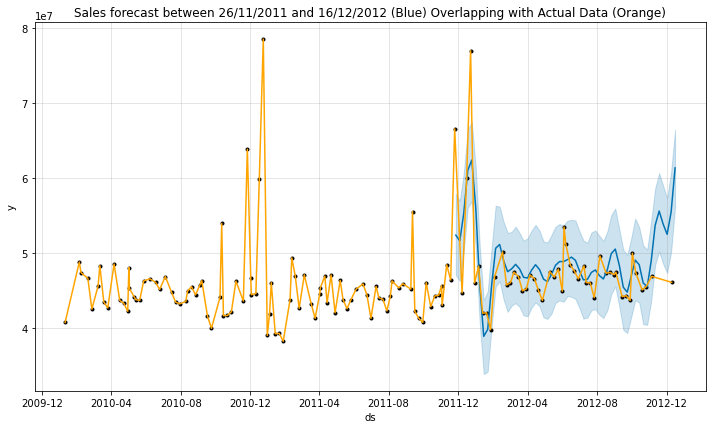

In [74]:
forecast_dates = model.predict(dates_for_forecast)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast_dates)

plt.plot(df1.ds, df1.y, color = 'orange')
plt.title('Sales forecast between 26/11/2011 and 16/12/2012 (Blue) Overlapping with Actual Data (Orange)')

plt.show()

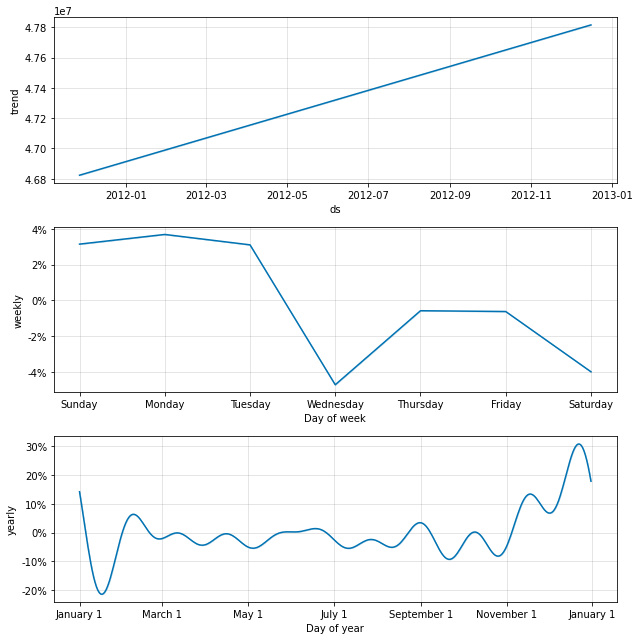

In [75]:
model.plot_components(forecast_dates);

In [76]:
# Import additional packages
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [77]:
df_cv = cross_validation(model, initial="366 days", horizon="366 days", period="183 days", parallel='processes') #seasonality is 1 full year equals to 365.25 days, so I decide to take 366 days as initial and horizon and half a year for the period

INFO:fbprophet:Making 2 forecasts with cutoffs between 2011-06-10 00:00:00 and 2011-12-10 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000001E56DA977F0>


In [78]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-06-17,4.583927e+07,4.101852e+07,5.095705e+07,45915446.91,2011-06-10
1,2011-06-24,4.584845e+07,4.055510e+07,5.110206e+07,44445264.43,2011-06-10
2,2011-07-01,4.460951e+07,3.924266e+07,4.976689e+07,41331055.49,2011-06-10
3,2011-07-10,4.550811e+07,4.018697e+07,5.065065e+07,45580698.41,2011-06-10
4,2011-07-15,4.358676e+07,3.870893e+07,4.846000e+07,44060809.95,2011-06-10
5,2011-07-22,4.416187e+07,3.920103e+07,4.984115e+07,43877484.57,2011-06-10
6,2011-07-29,4.379531e+07,3.861003e+07,4.890093e+07,42331054.49,2011-06-10
7,2011-08-04,4.217656e+07,3.680950e+07,4.668610e+07,44273207.45,2011-06-10
8,2011-08-07,4.446917e+07,3.926461e+07,4.919560e+07,46324414.14,2011-06-10
9,2011-08-19,4.446386e+07,3.925840e+07,4.936123e+07,45386586.19,2011-06-10


In [79]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,34 days,4.946226e+13,7.032941e+06,4.790568e+06,0.087490,0.075077,0.666667
1,35 days,4.858144e+13,6.970039e+06,4.525997e+06,0.083405,0.075077,0.666667
2,41 days,5.324449e+13,7.296882e+06,5.237385e+06,0.100327,0.079322,0.555556
3,42 days,1.965426e+13,4.433313e+06,3.336822e+06,0.075954,0.075077,0.666667
4,48 days,1.964044e+13,4.431753e+06,3.331816e+06,0.076234,0.075077,0.666667
5,49 days,1.134333e+13,3.367986e+06,2.520668e+06,0.058926,0.034591,0.777778
6,55 days,9.182287e+12,3.030229e+06,2.009521e+06,0.047522,0.034094,0.777778
7,58 days,9.564138e+12,3.092594e+06,2.207594e+06,0.051795,0.034591,0.777778
8,69 days,7.534268e+12,2.744862e+06,1.990417e+06,0.045036,0.034591,0.888889
9,70 days,7.603902e+12,2.757517e+06,2.040270e+06,0.046099,0.034591,0.888889


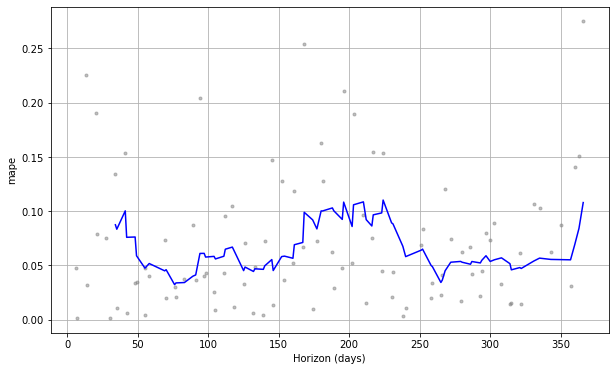

In [80]:
plot_cross_validation_metric(df_cv, metric = "mape", rolling_window=0.1, ax=None, figsize=(10, 6));

- I choose to employ FbProphet tool to build up forecasting model for overall sales value. I build two models With and Without Regressors, and applied the Without Regressors model to both in (using all historical data points up to 26/11/2011 and forecast for the period between 26/11/2011 and 16/12/2012) and out of sample case (use all historical data points to predict sales between 16/12/2012 and 30/12/2014) to test for the model accuracy.
- From the model components, we can see a clear seasonal trend of raising in the year-end holidays period (November and December) and a significant drop in February. Throughout the year, the sales are quite stable, and follows an uptrend.
- We can see from the in-sample forecast, the forecasted data peaks and troughs are a bit lagging behind compared to the actual data timeline. In addition, we can see there already was a shift in sales end of year 2012, where the forecasted sales for the holidays period overshoot the actual data by a long way.
- Finally, I attempt to do cross-validation on the training dataset with the fitted model; with the parameters of: initial="366 days", horizon="366 days" and period="183 days". Then I plot the MAPE metrics from the cross-validation results. As we can see, minimum MAPE value this model achieves the horizon is around 4% while the max value is around 11%. It is also interesting to observe that the MAPE value fluctuates with the length of the horizon periods. The MAPE value rises significantly between the horizon of 150 and 225 days, as well as after 350 days. This fluctuation might be driven by the seasonality factors.
- Next section, I present the FbProphet model with Regressors and applied it to forecast the weekly sales of the best and worst performance stores: store 20 and store 28.

## FBProphet with Regressors

In sample store 20 Sales forecast with Fbprophet model

Take CPI, Temperature, IsHoliday as regressors for our model

In [81]:
#temperature unit conversion
training['Temperature'] = (training['Temperature']- 32) * 5./9.

#factorize (Yes/No to 1/0 conversion)
holidays_factor, types = training['IsHoliday'].factorize()
training['IsHoliday'] = holidays_factor

training.head()

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Month,Day,Dept,Weekly_Sales
6587,1,0,151315,2011-11-11,15.061111,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,2011,11,11,1,18689.54
6588,1,0,151315,2011-11-11,15.061111,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,2011,11,11,2,44936.47
6589,1,0,151315,2011-11-11,15.061111,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,2011,11,11,3,9959.64
6590,1,0,151315,2011-11-11,15.061111,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,2011,11,11,4,36826.52
6591,1,0,151315,2011-11-11,15.061111,3.297,10382.9,6115.67,215.07,2406.62,6551.42,217.998085,7.866,0,2011,11,11,5,31002.65


***Predicting with regressors for best performance store: Store 20***

In [82]:
df_grouped_20 = training.query('Store == 20')\
    .groupby(['Date', 'IsHoliday', 'CPI', 'Temperature'], as_index = False)\
    .agg({'Weekly_Sales':'sum'})

In [83]:
df_grouped_20.head()

,Date,IsHoliday,CPI,Temperature,Weekly_Sales
0,2010-01-10,0,204.885097,16.155556,1933719.21
1,2010-02-04,0,204.025284,10.555556,2405395.22
2,2010-02-07,0,204.465056,21.166667,2143676.77
3,2010-02-19,0,204.432100,-3.650000,2161549.76
4,2010-02-26,0,204.463087,0.177778,1898193.95


In [84]:
#Data Preparation for Fbprophet

df_grouped_20 = df_grouped_20.rename(columns = {'Date':'ds','Weekly_Sales':'y'})

In [85]:
datetime_series = pd.to_datetime(df_grouped_20['ds'])

datetime_index = pd.DatetimeIndex(datetime_series.values)

Store20_data=df_grouped_20.set_index(datetime_index)

In [86]:
Store20_data.head()

,ds,IsHoliday,CPI,Temperature,y
2010-01-10,2010-01-10,0,204.885097,16.155556,1933719.21
2010-02-04,2010-02-04,0,204.025284,10.555556,2405395.22
2010-02-07,2010-02-07,0,204.465056,21.166667,2143676.77
2010-02-19,2010-02-19,0,204.432100,-3.650000,2161549.76
2010-02-26,2010-02-26,0,204.463087,0.177778,1898193.95


In [87]:
Store20_data.shape

(143, 5)

In [88]:
train_data_pr1 = Store20_data.iloc[:len(Store20_data)-40]
test_data_pr1 = Store20_data.iloc[len(Store20_data)-40:]

In [89]:
test_data_pr2 = test_data_pr1[['ds', 'IsHoliday', 'CPI', 'Temperature']]

In [90]:
# define the model
m1 = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, weekly_seasonality=True, changepoint_range=0.9)
m1.add_seasonality('weekly', period=7, fourier_order=15)

m1.add_regressor('IsHoliday')
m1.add_regressor('CPI')
m1.add_regressor('Temperature')
m1.fit(train_data_pr1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
35 2012-10-08  2.336791e+06  2.117397e+06  2.562181e+06
36 2012-10-19  2.097163e+06  1.868446e+06  2.334057e+06
37 2012-10-26  2.007895e+06  1.780866e+06  2.239863e+06
38 2012-11-05  2.263006e+06  2.036466e+06  2.495369e+06
39 2012-12-10  2.103235e+06  1.878870e+06  2.338590e+06


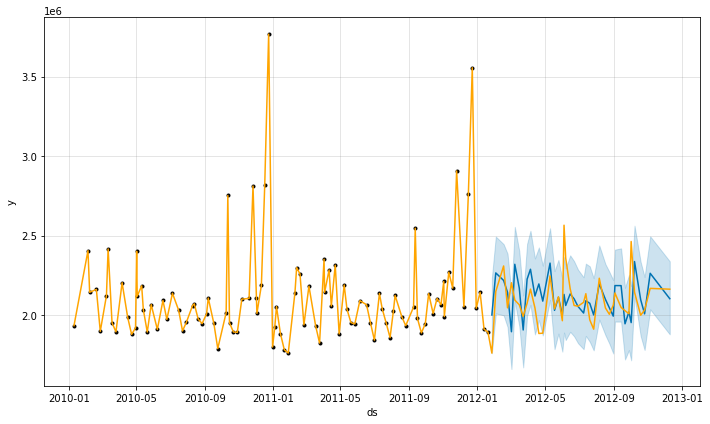

In [91]:
prophet_pred2 = m1.predict(test_data_pr2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred2)


plt.plot(Store20_data.ds, Store20_data.y, color = 'orange')

plt.show()

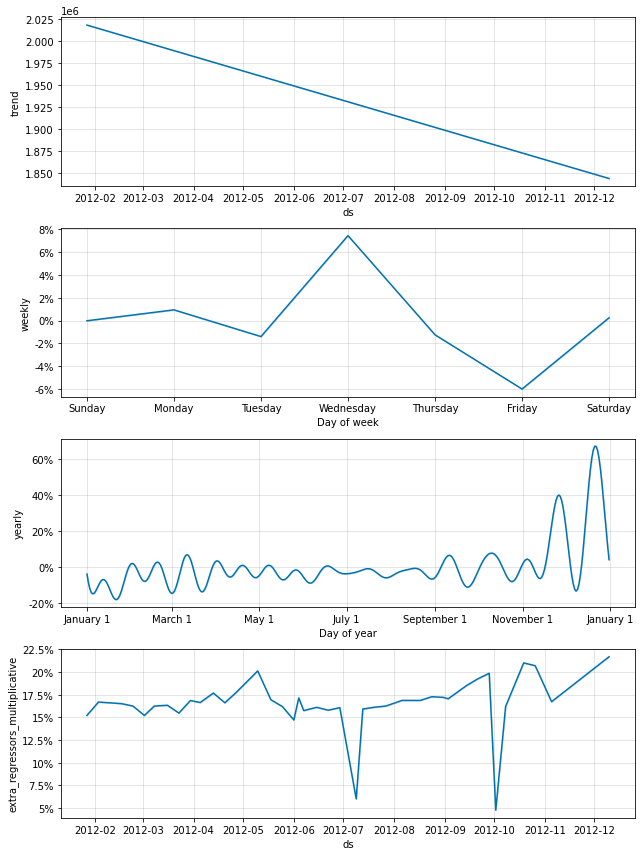

In [92]:
m1.plot_components(prophet_pred2);

In [93]:
Store20_data_2 = Store20_data[['ds', 'IsHoliday', 'CPI', 'Temperature']]

            ds          yhat    yhat_lower    yhat_upper
138 2012-10-08  2.336791e+06  2.120922e+06  2.581668e+06
139 2012-10-19  2.097163e+06  1.851556e+06  2.331316e+06
140 2012-10-26  2.007895e+06  1.772005e+06  2.237807e+06
141 2012-11-05  2.263006e+06  2.034513e+06  2.503179e+06
142 2012-12-10  2.103235e+06  1.866244e+06  2.324298e+06


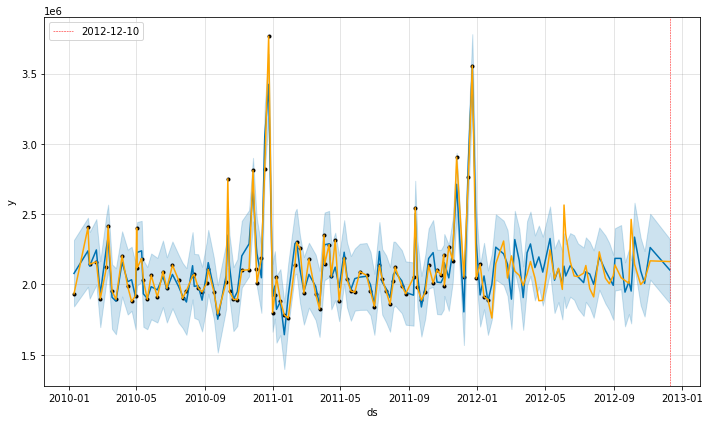

In [94]:
prophet_pred2 = m1.predict(Store20_data_2)


print(prophet_pred2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred2)


plt.plot(Store20_data.ds, Store20_data.y, color = 'orange')

for x in Store20_data[Store20_data['ds']=='2012-12-10']['ds']:
    plt.axvline(x=x, color='red', linewidth=0.5, ls='--', label='2012-12-10')
    

plt.legend()

plt.show()

In [95]:
prophet_pred3 = prophet_pred2[['ds','yhat']]

df_ds=pd.merge(Store20_data, prophet_pred3, on=['ds'], how='left')

df_ds['diff'] = (abs(df_ds['y']-df_ds['yhat'])/df_ds['y'])*100

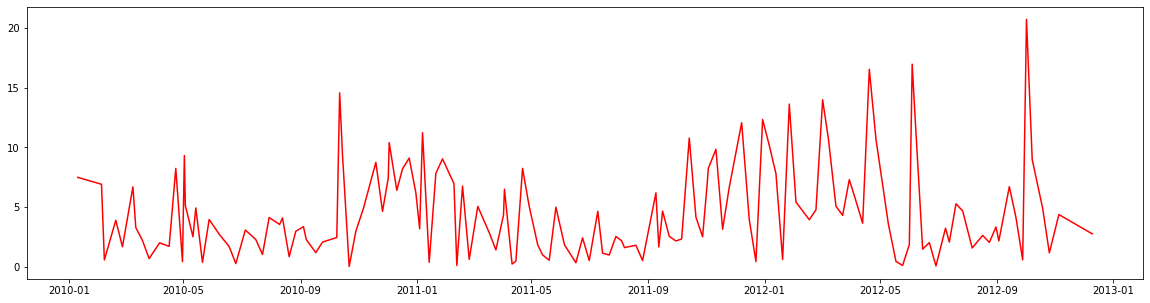

In [96]:
x1 = df_ds['ds']
y1 = df_ds['diff']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x1.values, y1.values, c='r')

In [97]:
df_ds[['diff']].describe()

,diff
count,143.000000
mean,4.601012
std,3.952155
min,0.033718
25%,1.759841
50%,3.547181
75%,6.703596
max,20.709402


***Predicting with regressors for worst performance store: Store 28***

In [98]:
df_grouped_28 = training.query('Store == 28')\
    .groupby(['Date', 'IsHoliday', 'CPI', 'Temperature'], as_index = False)\
    .agg({'Weekly_Sales':'sum'})

In [99]:
df_grouped_28.head()

,Date,IsHoliday,CPI,Temperature,Weekly_Sales
0,2010-01-10,0,126.234600,29.555556,1203080.41
1,2010-02-04,0,126.603484,15.466667,1441559.40
2,2010-02-07,0,126.139200,33.322222,1399960.15
3,2010-02-19,0,126.526286,12.683333,1491300.42
4,2010-02-26,0,126.552286,10.127778,1542173.33


In [100]:
#Data Preparation for Fbprophet

df_grouped_28 = df_grouped_28.rename(columns = {'Date':'ds','Weekly_Sales':'y'})

In [101]:
datetime_series = pd.to_datetime(df_grouped_28['ds'])

datetime_index = pd.DatetimeIndex(datetime_series.values)

Store28_data=df_grouped_28.set_index(datetime_index)

In [102]:
Store28_data.head()

,ds,IsHoliday,CPI,Temperature,y
2010-01-10,2010-01-10,0,126.234600,29.555556,1203080.41
2010-02-04,2010-02-04,0,126.603484,15.466667,1441559.40
2010-02-07,2010-02-07,0,126.139200,33.322222,1399960.15
2010-02-19,2010-02-19,0,126.526286,12.683333,1491300.42
2010-02-26,2010-02-26,0,126.552286,10.127778,1542173.33


In [103]:
train_data_pr3 = Store28_data.iloc[:len(Store28_data)-40]
test_data_pr3 = Store28_data.iloc[len(Store28_data)-40:]

In [104]:
test_data_pr4 = test_data_pr3[['ds', 'IsHoliday', 'CPI', 'Temperature']]

In [105]:
# redefine the model
m1 = Prophet(changepoint_prior_scale=0.05, interval_width=0.95,growth = 'linear',seasonality_mode = 'multiplicative', \
               yearly_seasonality=20, weekly_seasonality=True, changepoint_range=0.9)
m1.add_seasonality('weekly', period=7, fourier_order=15)

m1.add_regressor('IsHoliday')
m1.add_regressor('CPI')
m1.add_regressor('Temperature')
m1.fit(train_data_pr3)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           ds          yhat    yhat_lower    yhat_upper
35 2012-10-08  1.258543e+06  1.135027e+06  1.381724e+06
36 2012-10-19  1.149851e+06  1.026227e+06  1.278722e+06
37 2012-10-26  1.104616e+06  9.724814e+05  1.229327e+06
38 2012-11-05  1.403307e+06  1.269952e+06  1.534411e+06
39 2012-12-10  1.116477e+06  9.891654e+05  1.249883e+06


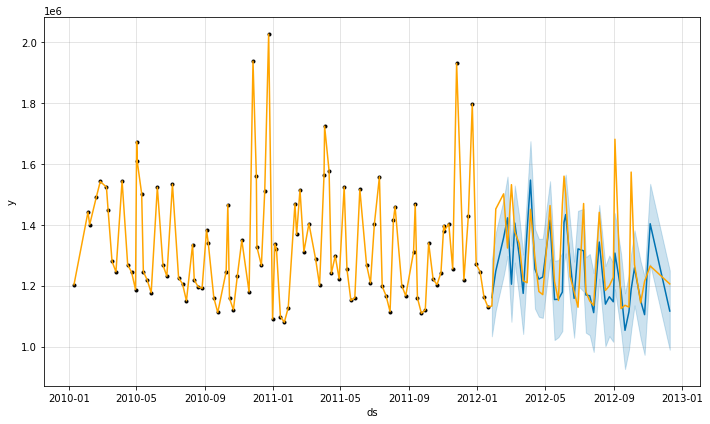

In [106]:
prophet_pred4 = m1.predict(test_data_pr4)


print(prophet_pred4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred4)


plt.plot(Store28_data.ds, Store28_data.y, color = 'orange')

plt.show()

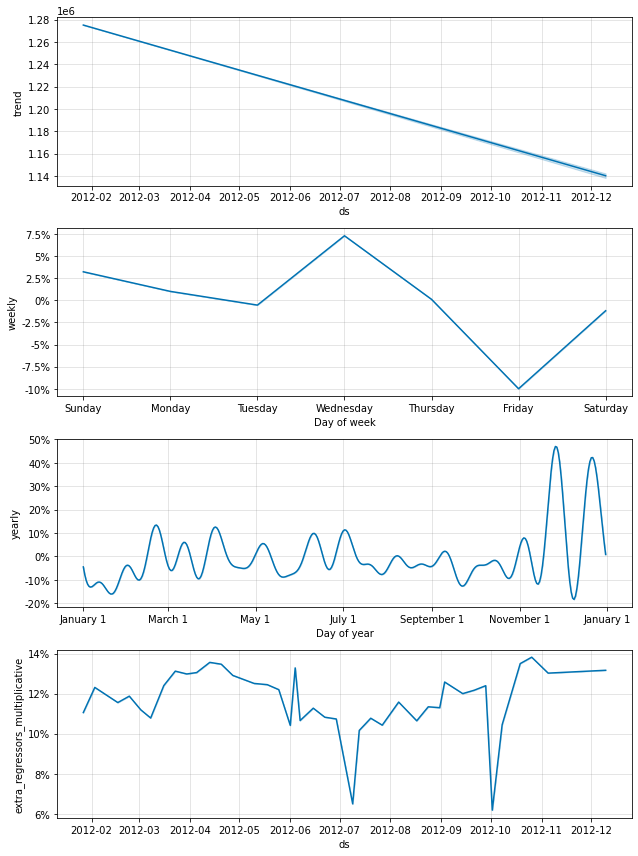

In [107]:
m1.plot_components(prophet_pred4);

In [108]:
Store28_data_2 = Store28_data[['ds', 'IsHoliday', 'CPI', 'Temperature']]

            ds          yhat    yhat_lower    yhat_upper
138 2012-10-08  1.258543e+06  1.120386e+06  1.391830e+06
139 2012-10-19  1.149851e+06  1.021479e+06  1.274638e+06
140 2012-10-26  1.104616e+06  9.717100e+05  1.246697e+06
141 2012-11-05  1.403307e+06  1.280654e+06  1.532698e+06
142 2012-12-10  1.116477e+06  9.842195e+05  1.237106e+06


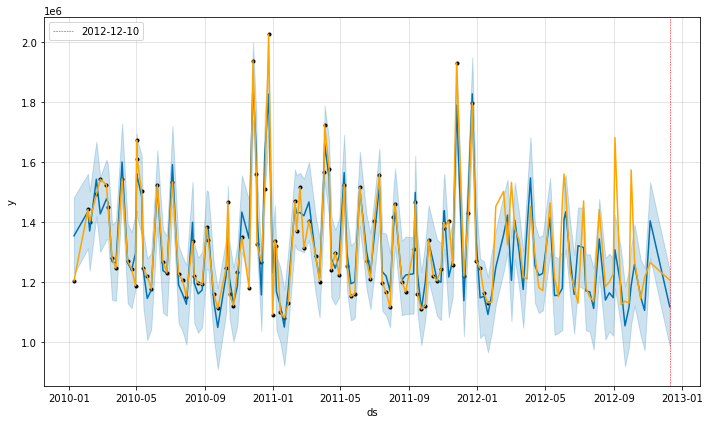

In [109]:
prophet_pred4 = m1.predict(Store28_data_2)


print(prophet_pred4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())
# plot forecast
m1.plot(prophet_pred4)


plt.plot(Store28_data.ds, Store28_data.y, color = 'orange')

for x in Store28_data[Store28_data['ds']=='2012-12-10']['ds']:
    plt.axvline(x=x, color='red', linewidth=0.5, ls='--', label='2012-12-10')
    

plt.legend()

plt.show()

In [110]:
prophet_pred5 = prophet_pred4[['ds','yhat']]

df_ds2=pd.merge(Store28_data, prophet_pred5, on=['ds'], how='left')

df_ds2['diff'] = (abs(df_ds2['y']-df_ds2['yhat'])/df_ds2['y'])*100

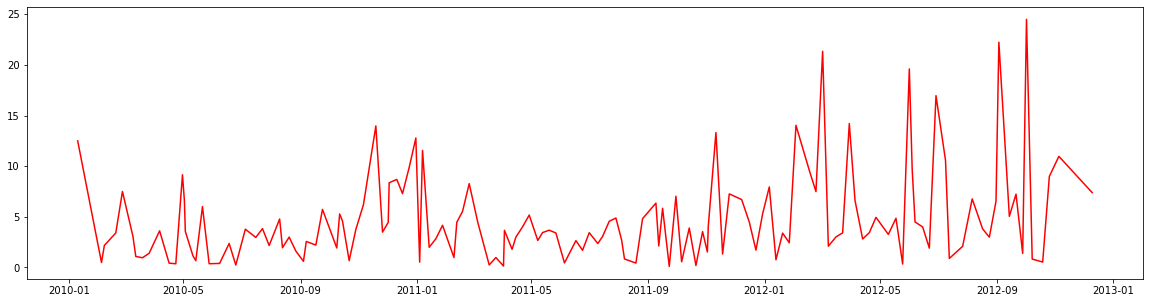

In [111]:
x2 = df_ds2['ds']
y2 = df_ds2['diff']
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(x2.values, y2.values, c='r')

In [112]:
df_ds2[['diff']].describe()

,diff
count,143.000000
mean,4.724372
std,4.521102
min,0.102082
25%,1.753809
50%,3.489757
75%,6.283317
max,24.499538


From the two set of forecasting results above, I can make the following conclusions:
- The model combines the standard FbProphet model with the following Regressor features: 'Holiday Day', 'CPI' and 'Temperature'.
- The model with Regressors performs slightly better with the better performing store with a lower mean and standard deviation value in Absolute Percentage Error (APE) measure (of 4.6 vs 4.72 and 3.95 vs 4.52 respectively).
- Achieving between 4.6 and 4.7% in the mean value of APE is quite good, and this model only has its accuracy deteriorated in the holidays period, the maximum percent error of around 20%.

For the stores' managers, the performance of both of these models mean that they can predict pretty well the sales amount up to a year ahead with quite good average accuracy of 5%; however, they need to take extra caution to not fully rely on the forecasted value during the holidays periods, as the models perform poorly during this time.